# Q-GAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [3]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.00464455 -0.17928359 -0.04387961  0.32460289] 0 1.0 False {}
state, action, reward, done, info
[-0.00823023  0.01643479 -0.03738756  0.01841144] 1 1.0 False {}
state, action, reward, done, info
[-0.00790153  0.21207242 -0.03701933 -0.28582931] 1 1.0 False {}
state, action, reward, done, info
[-0.00366008  0.01749745 -0.04273591 -0.00504801] 0 1.0 False {}
state, action, reward, done, info
[-0.00331013  0.21320541 -0.04283687 -0.31090246] 1 1.0 False {}
state, action, reward, done, info
[ 0.00095398  0.40891066 -0.04905492 -0.61678122] 1 1.0 False {}
state, action, reward, done, info
[ 0.00913219  0.60468236 -0.06139055 -0.92450188] 1 1.0 False {}
state, action, reward, done, info
[ 0.02122584  0.80057741 -0.07988059 -1.23582841] 1 1.0 False {}
state, action, reward, done, info
[ 0.03723738  0.99662986 -0.10459715 -1.55242926] 1 1.0 False {}
state, action, reward, done, info
[ 0.05716998  1.19283899 -0.13564574 -1.87582996] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1928389892596862 -1.875829956314631


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

In [6]:
# Data of the model
def model_input(state_size):
    # Current states given
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Next states given
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Current actions given
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # TargetQs/values
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    
    # returning the given data to the model
    return states, next_states, actions, targetQs

In [7]:
# Q: Qfunction/Encoder
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [8]:
# G: Generator/Decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [9]:
# D: Descriminator/Reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [10]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    # DQN: Q-learning - Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, d_loss, g_loss, rewards_fake, rewards_real

In [11]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations in order
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

In [12]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.d_loss, self.g_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, 
            states=self.states, next_states=self.next_states, actions=self.actions, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, q_loss=self.q_loss, 
                                                       learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [13]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [14]:
train_episodes = 500          # max number of episodes to learn from
max_steps = 2000              # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [15]:
tf.reset_default_graph()

model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [16]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [17]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, 
                         model.targetQs: targetQs}
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/Q-GAN-cartpole.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/Q-GAN-cartpole.ckpt
-------------------------------------------------------------------------------
Episode: 0 Total reward: 6.0 Average reward fake: 0.5262561440467834 Average reward real: 0.6110993027687073 Training q_loss: 1305991.0000 Training g_loss: 0.6420 Training d_loss: 1.2431 Explore P: 0.9994
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 16.0 Average reward fake: 0.45489436388015747 Average reward real: 0.5582472085952759 Training q_loss: 4395075.5000 Training g_loss: 0.7877 Training d_loss: 1.2161 Explore P: 0.9978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 9.0 Average reward fake: 0.4416735768318176 Average reward real: 0.5409927368164062 Train

-------------------------------------------------------------------------------
Episode: 23 Total reward: 38.0 Average reward fake: 0.5044890642166138 Average reward real: 0.5606293678283691 Training q_loss: 4556363.5000 Training g_loss: 0.6842 Training d_loss: 1.2892 Explore P: 0.9442
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 19.0 Average reward fake: 0.48241668939590454 Average reward real: 0.5059512853622437 Training q_loss: 1168862.7500 Training g_loss: 0.7289 Training d_loss: 1.3450 Explore P: 0.9424
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 16.0 Average reward fake: 0.4876479506492615 Average reward real: 0.5032670497894287 Training q_loss: 137469856.0000 Training g_loss: 0.7182 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 47 Total reward: 13.0 Average reward fake: 0.5282212495803833 Average reward real: 0.5143269300460815 Training q_loss: 4657642.0000 Training g_loss: 0.6398 Training d_loss: 1.4777 Explore P: 0.9003
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 18.0 Average reward fake: 0.6084115505218506 Average reward real: 0.5217997431755066 Training q_loss: 4833886.0000 Training g_loss: 0.4986 Training d_loss: 1.6161 Explore P: 0.8987
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 49 Total reward: 50.0 Average reward fake: 0.5109856128692627 Average reward real: 0.687839150428772 Training q_loss: 4558663.0000 Training g_loss: 0.6746 Training d_loss: 1.107

-------------------------------------------------------------------------------
Episode: 70 Total reward: 15.0 Average reward fake: 0.5059080719947815 Average reward real: 0.4365765154361725 Training q_loss: 3112047.5000 Training g_loss: 0.6814 Training d_loss: 1.5509 Explore P: 0.8604
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 28.0 Average reward fake: 0.5430368185043335 Average reward real: 0.498473584651947 Training q_loss: 28078336.0000 Training g_loss: 0.6107 Training d_loss: 1.4819 Explore P: 0.8580
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 72 Total reward: 21.0 Average reward fake: 0.5214719176292419 Average reward real: 0.5506240129470825 Training q_loss: 18199840.0000 Training g_loss: 0.6511 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 93 Total reward: 21.0 Average reward fake: 0.3345896601676941 Average reward real: 0.8080335855484009 Training q_loss: 2664895.0000 Training g_loss: 1.1426 Training d_loss: 0.7539 Explore P: 0.8184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 24.0 Average reward fake: 0.34168127179145813 Average reward real: 0.8901525735855103 Training q_loss: 1581107.8750 Training g_loss: 1.8241 Training d_loss: 1.1896 Explore P: 0.8165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 95 Total reward: 35.0 Average reward fake: 0.3793720304965973 Average reward real: 0.8647801280021667 Training q_loss: 3282742.5000 Training g_loss: 2.3678 Training d_loss: 1.2

-------------------------------------------------------------------------------
Episode: 116 Total reward: 25.0 Average reward fake: 0.5040512084960938 Average reward real: 0.5001716613769531 Training q_loss: 2185212.0000 Training g_loss: 0.6892 Training d_loss: 1.4287 Explore P: 0.7768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 11.0 Average reward fake: 0.4987707734107971 Average reward real: 0.5154866576194763 Training q_loss: 2704016.5000 Training g_loss: 0.6983 Training d_loss: 1.3655 Explore P: 0.7759
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 118 Total reward: 9.0 Average reward fake: 0.48774319887161255 Average reward real: 0.5323259234428406 Training q_loss: 2577270.5000 Training g_loss: 0.7181 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 139 Total reward: 58.0 Average reward fake: 0.45033225417137146 Average reward real: 0.5680059194564819 Training q_loss: 1300271.5000 Training g_loss: 0.8306 Training d_loss: 1.2168 Explore P: 0.7149
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 10.0 Average reward fake: 0.42819246649742126 Average reward real: 0.5903957486152649 Training q_loss: 2059861.7500 Training g_loss: 0.8964 Training d_loss: 1.1698 Explore P: 0.7142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 141 Total reward: 27.0 Average reward fake: 0.4760950207710266 Average reward real: 0.5193063020706177 Training q_loss: 1306259.6250 Training g_loss: 0.7942 Training d_loss:

-------------------------------------------------------------------------------
Episode: 162 Total reward: 107.0 Average reward fake: 0.5027928948402405 Average reward real: 0.4888199269771576 Training q_loss: 504957.1875 Training g_loss: 0.6877 Training d_loss: 1.4419 Explore P: 0.6397
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 138.0 Average reward fake: 0.49423637986183167 Average reward real: 0.4997483789920807 Training q_loss: 606957.2500 Training g_loss: 0.7051 Training d_loss: 1.4036 Explore P: 0.6311
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 164 Total reward: 53.0 Average reward fake: 0.5070425271987915 Average reward real: 0.5201699137687683 Training q_loss: 182628.5938 Training g_loss: 0.6792 Training d_loss: 1

-------------------------------------------------------------------------------
Episode: 185 Total reward: 19.0 Average reward fake: 0.49615684151649475 Average reward real: 0.5675538182258606 Training q_loss: 189611.2656 Training g_loss: 0.7127 Training d_loss: 1.3192 Explore P: 0.5646
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 139.0 Average reward fake: 0.5615941286087036 Average reward real: 0.540309488773346 Training q_loss: 315944.5938 Training g_loss: 0.5791 Training d_loss: 1.4502 Explore P: 0.5569
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 187 Total reward: 77.0 Average reward fake: 0.5071635246276855 Average reward real: 0.5853133201599121 Training q_loss: 575646.5000 Training g_loss: 0.6796 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 208 Total reward: 47.0 Average reward fake: 0.38330894708633423 Average reward real: 0.5044348835945129 Training q_loss: 59326.8320 Training g_loss: 0.9775 Training d_loss: 1.1944 Explore P: 0.4686
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 71.0 Average reward fake: 0.41314858198165894 Average reward real: 0.48632001876831055 Training q_loss: 4020848.5000 Training g_loss: 1.0605 Training d_loss: 1.4836 Explore P: 0.4654
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 210 Total reward: 99.0 Average reward fake: 0.27363166213035583 Average reward real: 0.6379634737968445 Training q_loss: 209153.1562 Training g_loss: 2.8541 Training d_loss: 

-------------------------------------------------------------------------------
Episode: 231 Total reward: 199.0 Average reward fake: 0.4515911936759949 Average reward real: 0.5945852398872375 Training q_loss: 81462.0547 Training g_loss: 0.7978 Training d_loss: 1.1496 Explore P: 0.3591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 179.0 Average reward fake: 0.5818535685539246 Average reward real: 0.4494269788265228 Training q_loss: 137997.5938 Training g_loss: 0.5419 Training d_loss: 1.7481 Explore P: 0.3529
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 159.0 Average reward fake: 0.5427787899971008 Average reward real: 0.3623526096343994 Training q_loss: 188202.2969 Training g_loss: 0.6120 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 254 Total reward: 199.0 Average reward fake: 0.5138804316520691 Average reward real: 0.5903687477111816 Training q_loss: 60498.7266 Training g_loss: 0.6659 Training d_loss: 1.2578 Explore P: 0.2413
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 199.0 Average reward fake: 0.5087089538574219 Average reward real: 0.47334736585617065 Training q_loss: 63171.5859 Training g_loss: 0.6759 Training d_loss: 1.4634 Explore P: 0.2367
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 199.0 Average reward fake: 0.49060407280921936 Average reward real: 0.4797055721282959 Training q_loss: 40289.8633 Training g_loss: 0.7122 Training d_loss: 1.

-------------------------------------------------------------------------------
Episode: 277 Total reward: 199.0 Average reward fake: 0.585004985332489 Average reward real: 0.6277991533279419 Training q_loss: 17215.5137 Training g_loss: 0.5368 Training d_loss: 1.3958 Explore P: 0.1568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 199.0 Average reward fake: 0.5486668348312378 Average reward real: 0.4086364209651947 Training q_loss: 57581.5117 Training g_loss: 0.6009 Training d_loss: 1.8041 Explore P: 0.1539
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 199.0 Average reward fake: 0.40930014848709106 Average reward real: 0.5597687363624573 Training q_loss: 14872.9424 Training g_loss: 0.8939 Training d_loss: 1.11

-------------------------------------------------------------------------------
Episode: 300 Total reward: 199.0 Average reward fake: 0.5125598311424255 Average reward real: 0.48914116621017456 Training q_loss: 762.8004 Training g_loss: 0.6683 Training d_loss: 1.4362 Explore P: 0.1043
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 199.0 Average reward fake: 0.5227876305580139 Average reward real: 0.5084923505783081 Training q_loss: 38246.5703 Training g_loss: 0.6486 Training d_loss: 1.4197 Explore P: 0.1024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 137.0 Average reward fake: 0.5084560513496399 Average reward real: 0.5126768350601196 Training q_loss: 408.9256 Training g_loss: 0.6764 Training d_loss: 1.3870 

-------------------------------------------------------------------------------
Episode: 323 Total reward: 199.0 Average reward fake: 0.45099353790283203 Average reward real: 0.48914995789527893 Training q_loss: 5231.6650 Training g_loss: 0.7991 Training d_loss: 1.3258 Explore P: 0.0708
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 324 Total reward: 199.0 Average reward fake: 0.5347397923469543 Average reward real: 0.4464566707611084 Training q_loss: 1781.7115 Training g_loss: 0.6261 Training d_loss: 1.6338 Explore P: 0.0696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 199.0 Average reward fake: 0.49682727456092834 Average reward real: 0.5051576495170593 Training q_loss: 15561.2529 Training g_loss: 0.6996 Training d_loss: 1.3

-------------------------------------------------------------------------------
Episode: 346 Total reward: 199.0 Average reward fake: 0.46787557005882263 Average reward real: 0.38818874955177307 Training q_loss: 13382.6436 Training g_loss: 0.7611 Training d_loss: 1.6073 Explore P: 0.0485
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 347 Total reward: 199.0 Average reward fake: 0.5075169801712036 Average reward real: 0.5543404817581177 Training q_loss: 977.5958 Training g_loss: 0.6798 Training d_loss: 1.3095 Explore P: 0.0477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 197.0 Average reward fake: 0.5359110236167908 Average reward real: 0.5044376850128174 Training q_loss: 397.4476 Training g_loss: 0.6220 Training d_loss: 1.4792

-------------------------------------------------------------------------------
Episode: 369 Total reward: 199.0 Average reward fake: 0.4947262406349182 Average reward real: 0.5091459155082703 Training q_loss: 2329.2788 Training g_loss: 0.7057 Training d_loss: 1.3698 Explore P: 0.0344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 370 Total reward: 199.0 Average reward fake: 0.4553699493408203 Average reward real: 0.5248810052871704 Training q_loss: 1662.1719 Training g_loss: 0.7886 Training d_loss: 1.2569 Explore P: 0.0339
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 371 Total reward: 199.0 Average reward fake: 0.49902087450027466 Average reward real: 0.510581374168396 Training q_loss: 8773.2012 Training g_loss: 0.6951 Training d_loss: 1.3670 

-------------------------------------------------------------------------------
Episode: 392 Total reward: 187.0 Average reward fake: 0.4876576364040375 Average reward real: 0.4867278039455414 Training q_loss: 1880.4098 Training g_loss: 0.7222 Training d_loss: 1.8035 Explore P: 0.0255
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 393 Total reward: 199.0 Average reward fake: 0.5346835255622864 Average reward real: 0.5187641382217407 Training q_loss: 1646.0807 Training g_loss: 0.6300 Training d_loss: 1.4336 Explore P: 0.0252
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 394 Total reward: 199.0 Average reward fake: 0.46145081520080566 Average reward real: 0.5397990345954895 Training q_loss: 145806.1562 Training g_loss: 0.7734 Training d_loss: 1.24

-------------------------------------------------------------------------------
Episode: 415 Total reward: 194.0 Average reward fake: 0.5372955799102783 Average reward real: 0.38968273997306824 Training q_loss: 9865.8535 Training g_loss: 0.6218 Training d_loss: 1.7614 Explore P: 0.0201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 416 Total reward: 180.0 Average reward fake: 0.5761961936950684 Average reward real: 0.5349763631820679 Training q_loss: 1715.4824 Training g_loss: 0.5519 Training d_loss: 1.4953 Explore P: 0.0199
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 417 Total reward: 188.0 Average reward fake: 0.4764999747276306 Average reward real: 0.4522925913333893 Training q_loss: 3066.3245 Training g_loss: 0.7414 Training d_loss: 1.4521

-------------------------------------------------------------------------------
Episode: 438 Total reward: 199.0 Average reward fake: 0.4993310868740082 Average reward real: 0.5522290468215942 Training q_loss: 242.6037 Training g_loss: 0.6949 Training d_loss: 1.3064 Explore P: 0.0167
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 439 Total reward: 199.0 Average reward fake: 0.4544784426689148 Average reward real: 0.5522936582565308 Training q_loss: 821.3441 Training g_loss: 0.7902 Training d_loss: 1.2247 Explore P: 0.0165
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 440 Total reward: 199.0 Average reward fake: 0.502521812915802 Average reward real: 0.4809119701385498 Training q_loss: 1894.8832 Training g_loss: 0.6900 Training d_loss: 1.4612 Exp

-------------------------------------------------------------------------------
Episode: 461 Total reward: 106.0 Average reward fake: 0.4843223989009857 Average reward real: 0.4456663131713867 Training q_loss: 1389.7559 Training g_loss: 0.7254 Training d_loss: 1.5042 Explore P: 0.0144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 123.0 Average reward fake: 0.4922129213809967 Average reward real: 0.5201836824417114 Training q_loss: 139.5284 Training g_loss: 0.7086 Training d_loss: 1.3527 Explore P: 0.0143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 180.0 Average reward fake: 0.47298726439476013 Average reward real: 0.48117274045944214 Training q_loss: 8565.1924 Training g_loss: 0.7493 Training d_loss: 1.3956

-------------------------------------------------------------------------------
Episode: 484 Total reward: 153.0 Average reward fake: 0.5465416312217712 Average reward real: 0.5558545589447021 Training q_loss: 2891.2300 Training g_loss: 0.6414 Training d_loss: 1.4606 Explore P: 0.0134
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 485 Total reward: 161.0 Average reward fake: 0.5182978510856628 Average reward real: 0.48949456214904785 Training q_loss: 3937.9062 Training g_loss: 0.6572 Training d_loss: 1.4963 Explore P: 0.0133
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 486 Total reward: 169.0 Average reward fake: 0.4814396798610687 Average reward real: 0.40814629197120667 Training q_loss: 3630.9116 Training g_loss: 0.7325 Training d_loss: 1.610

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

In [ ]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

Text(0,0.5,'G losses')

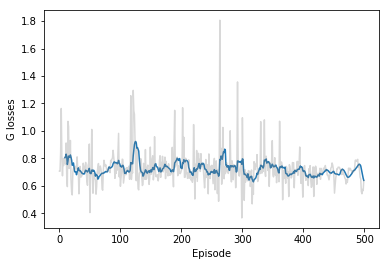

In [61]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

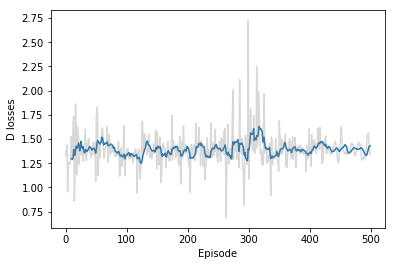

In [62]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [44]:
test_episodes = 5
test_max_steps = 200
env.reset()

with tf.Session() as sess:
    
    # Restore/load the trained model 
    saver.restore(sess, 'checkpoints/Q-GAN-cartpole.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            #env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/Q-GAN-cartpole.ckpt


## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.